# AICE Professional 특강 - 이미지 실습
+ 본과정에서는 꽃 이미지 데이터를 가지고 이미지 모델을 만들고
 분류 실습하겠습니다.
+ 첫번째로, 이미지 파일 읽고 , 라벨정보도 만들어 데이터셋을 생성하고
+ 만들어진 데이터셋을 활용하여 CNN 모델 학습하고 평가하겠습니다.
+ 두번째로, 이미지 파일 읽고, 라벨정보 만드는 작업을 Keras의 image_dataset_from_directory 함수 활용하여
+ 데이터셋을 만들고 CNN 모델 학습 및 평가 하겠습니다.
+ 세번째로, MobileNet Transfer Learning(전이학습)으로 모델 학습 및 평가 진행하겠습니다.

<br>
<br>



## A. 라벨정보 포함한 이미지 데이터셋 만들기

### 1.필요한 라이브러리 임포트

In [1]:
import os
from glob import glob
from PIL import Image

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

## E. MobileNet Transfer Learning & Fine-tuning 모델링

### 1. Build Model

In [36]:
# 약 3,700장의 꽃 사진 데이터세트를 사용합니다.
# 아래 데이터 가져오기 그냥 사용합니다.

import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [37]:
# 하이터 파라미터 정의
input_shape = (224, 224, 3)
batch_size = 32
num_classes = 5

In [64]:
# 이미지 패스 지정
img_path ='/root/.keras/datasets/flower_photos/'

In [39]:
# image_dataset_from_directory 함수 활용하여
# 이미지 폴더 밑의 이미지들에 대해 원핫인코딩된 labeling수행, 이미지 배치, 셔플 수행

# Train Dataset 만들기
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
                                             directory=img_path,
                                             label_mode="categorical",   # binary , categorical
                                             batch_size=batch_size,
                                             image_size=(224, 224),      # 사이즈 확인
                                             seed=42,
                                             shuffle=True,
                                             validation_split=0.2,
                                             subset="training"    # One of "training" or "validation". Only used if validation_split is set.
                                            )

# Test Dataset 만들기
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
                                             directory=img_path,
                                             label_mode="categorical",   # binary , categorical
                                             batch_size=batch_size,
                                             image_size=(224, 224),      # 사이즈 확인
                                             seed=42,
                                             validation_split=0.2,
                                             subset="validation"    # One of "training" or "validation". Only used if validation_split is set.
                                            )

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [28]:
# 사전 훈련된 모델 MobileNetV2에서 기본 모델을 생성합니다.
# 아래와 같은 형식을 MobileNetV2 Transfer Learning 사용하며 됩니다.

base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# tf.keras.applications.MobileNetV2 모델은 [-1, 1]의 픽셀 값을 예상하지만 이 시점에서 이미지의 픽셀 값은 [0, 255]입니다.
# MobileNetV2 모델에서 제대로 수행하기 위해 크기를 [-1, 1]로 재조정해야 합니다.(안하고 수행해도 성능 잘 나옴)
# 방법 2가지 있음
# 첫번째 방법 : preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
# 두번째 방법 : rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [30]:
# MobileNet V2 베이스 모델 고정하기
base_model.trainable = False

In [32]:
# 모델 구축 : 이미지 픽셀값 조정 수행하기(Rescaling) --> 성능 더 잘 나옴.

inputs = tf.keras.Input(shape=(224, 224, 3))
x = tf.keras.layers.Rescaling(1./127.5, offset=-1)(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)  # 3차원(7, 7, 1280) --> 1차원(1280)으로 줄이기 : GlobalAveragePooling2D
#이미지 갯수 5개
output = tf.keras.layers.Dense(5, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=output)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │           6,405 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,264,389 (8.64 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [46]:
# 모델 compile
learning_rate = 0.0003
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),  # Optimization
              loss='categorical_crossentropy',  # Loss Function
              metrics=['accuracy'])             # Metrics / Accuracy

### 2. Callback

In [47]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

# ModelCheckpoint
checkpoint_path = "my_checkpoint.keras"
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             save_best_only=True,
                             monitor='val_loss',
                             verbose=1)

### 3. 모델 학습

In [48]:
# image_dataset_from_directory 이용하여 DataSet을 만들었으며
# num_epochs = 10
# batch_size = 32

history = model.fit(
    train_ds,
    validation_data = test_ds,
    epochs=10,
    callbacks=[es, checkpoint]
)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9858 - loss: 0.0833
Epoch 1: val_loss improved from inf to 0.30739, saving model to my_checkpoint.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 138ms/step - accuracy: 0.9858 - loss: 0.0833 - val_accuracy: 0.9128 - val_loss: 0.3074
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9898 - loss: 0.0772
Epoch 2: val_loss improved from 0.30739 to 0.30561, saving model to my_checkpoint.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.9898 - loss: 0.0772 - val_accuracy: 0.9128 - val_loss: 0.3056
Epoch 3/10
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9877 - loss: 0.0744
Epoch 3: val_loss did not improve from 0.30561
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - accuracy: 0.9877 - loss: 0.0745 - val_accuracy: 0.9101 - val_loss: 0.3096
Epoch 4/10
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9900 - loss: 0.0700
Epoch 4: val_loss did not improve from 0.30561
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - ac

### 4. 성능 그래프

In [43]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

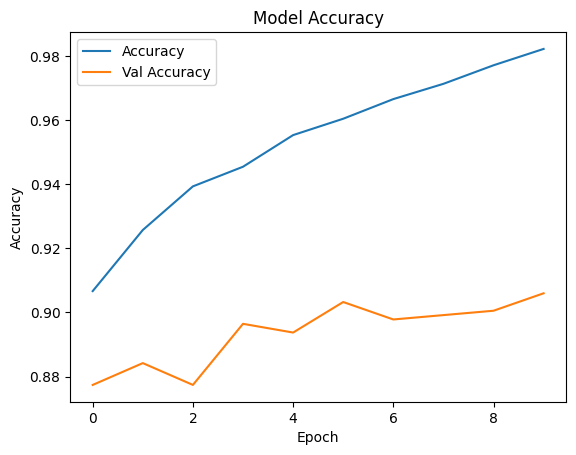

In [45]:
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

### 5. Predict

In [49]:
# test_generator 샘플 데이터 가져오기
# 배치 사이즈 32 확인

batch_img, batch_label = next(iter(test_ds))
print(batch_img.shape)
print(batch_label.shape)

(32, 224, 224, 3)
(32, 5)


In [50]:
# 이미지 rescale 되어 있는 상태
batch_img[0][0][:10]

<tf.Tensor: shape=(10, 3), dtype=float32, numpy=
array([[105.3919  , 144.3919  , 203.3919  ],
       [107.66677 , 146.66676 , 203.85109 ],
       [106.      , 145.      , 201.83928 ],
       [106.10491 , 145.1049  , 201.3549  ],
       [105.60683 , 144.60683 , 203.60683 ],
       [106.175385, 145.17538 , 204.17538 ],
       [105.015945, 144.01595 , 203.01595 ],
       [107.75893 , 146.75893 , 201.75893 ],
       [107.      , 146.      , 201.      ],
       [107.      , 146.      , 201.      ]], dtype=float32)>

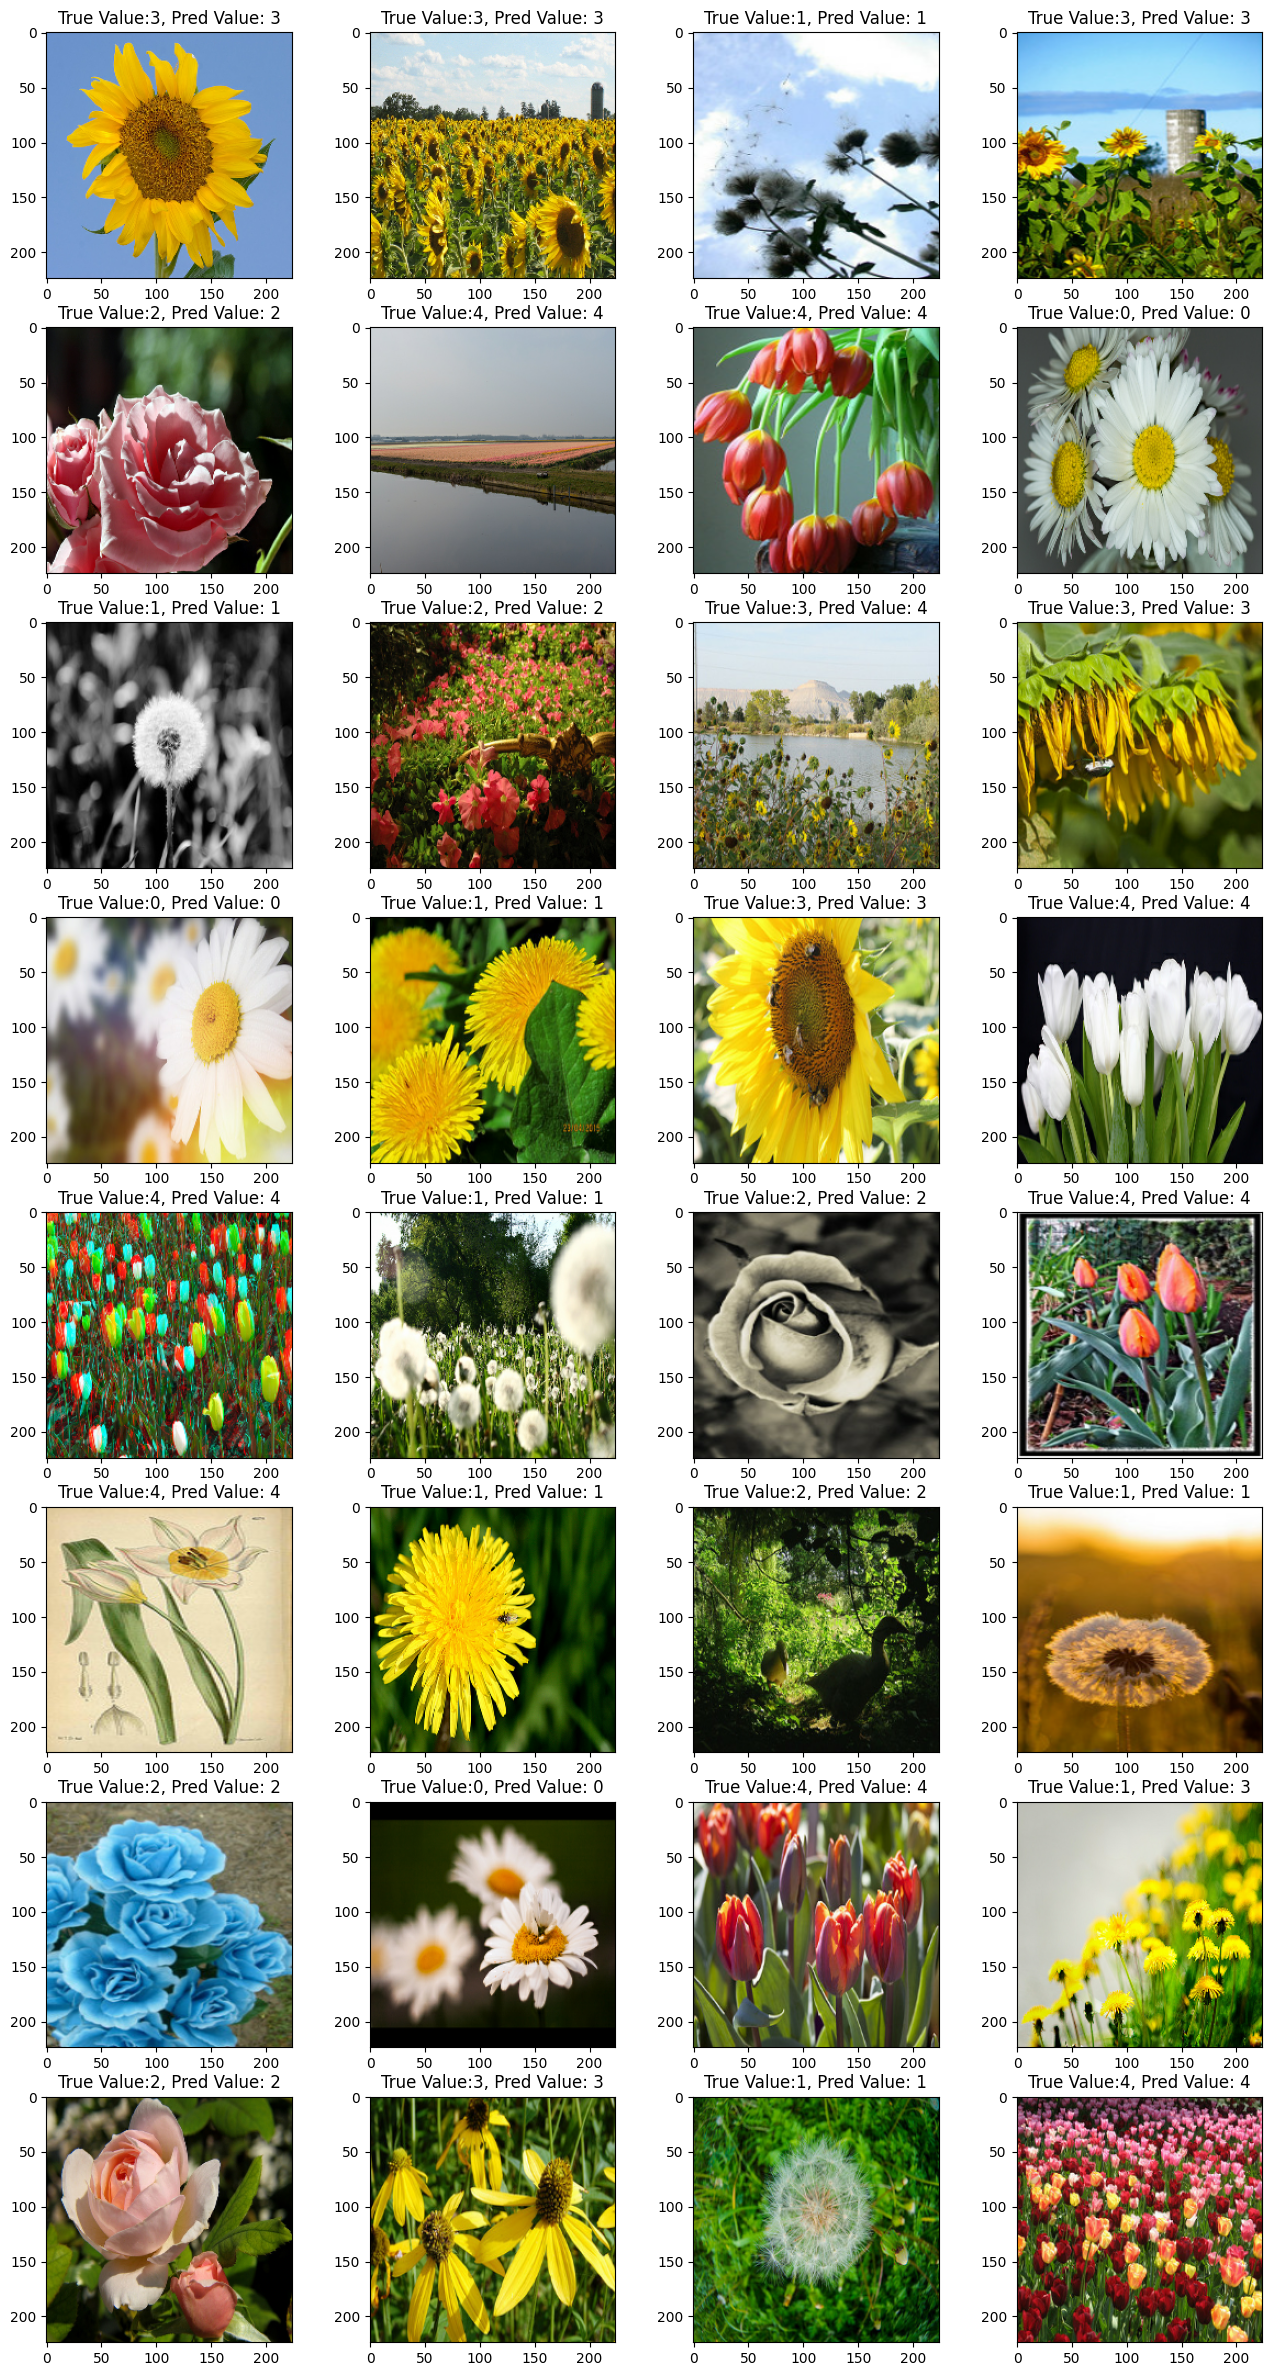

In [51]:
# 100% 성능 보여줌

i = 1
plt.figure(figsize=(16, 30))
for img, label in list(zip(batch_img, batch_label)):
    pred = model.predict(img.numpy().reshape(-1, 224,224,3), verbose=0)
    pred_t = np.argmax(pred)
    plt.subplot(8, 4, i)
    plt.title(f'True Value:{np.argmax(label)}, Pred Value: {pred_t}')
    plt.imshow(img/255)  # 이미지 픽셀값들이 실수형이므로 0~1 사이로 변경해야 에러 안남
    i = i + 1

In [52]:
from keras.preprocessing import image

In [60]:
def predict_images_in_directory(model, folder_path, img_width, img_height):
    results = []
    images = []
    filenames = []

    # 디렉토리 내의 모든 이미지 파일 로드
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        # 이미지 로드 및 전처리
        img = image.load_img(img_path)
        img = img.numpy().reshape(-1, 224,224,3)
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)

        images.append(img_array)
        filenames.append(filename)

    # 배치 처리를 위해 이미지 스택 생성
    images = np.vstack(images)

    # 예측 수행
    predictions = model.predict(images)

    # 결과 저장
    for filename, pred in zip(filenames, predictions):
        results.append([filename, pred])

    return results

In [55]:
!ls -al /root/.keras/datasets/flower_photos/

total 624
drwxr-x--- 7 270850 5000   4096 Feb 10  2016 .
drwxr-xr-x 3 root   root   4096 Oct 30 13:06 ..
drwx------ 2 270850 5000  36864 Feb 10  2016 daisy
drwx------ 2 270850 5000  45056 Feb 10  2016 dandelion
-rw-r----- 1 270850 5000 418049 Feb  9  2016 LICENSE.txt
drwx------ 2 270850 5000  36864 Feb 10  2016 roses
drwx------ 2 270850 5000  36864 Feb 10  2016 sunflowers
drwx------ 2 270850 5000  49152 Feb 10  2016 tulips


In [ ]:
def predict_images_in_directory(model, img_path, batch_size=32):
    class_names = train_ds.class_names
    print("클래스 매핑:", dict(enumerate(class_names)))

    image_files = []
    image_arrays = []

    # 이미지 수집 및 전처리
    for filename in os.listdir(img_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_file_path = os.path.join(img_path, filename)

            # 이미지 로드 및 전처리
            img = tf.keras.preprocessing.image.load_img(
                img_file_path,
                target_size=(224, 224)
            )
            img_array = tf.keras.preprocessing.image.img_to_array(img)

            image_files.append(filename)
            image_arrays.append(img_array)

    # 배치 처리를 위해 numpy 배열로 변환
    image_arrays = np.array(image_arrays)

    # 한 번에 예측 수행
    predictions = model.predict(image_arrays, batch_size=batch_size, verbose=1)
    predicted_classes = [class_names[np.argmax(pred)] for pred in predictions]

    # 결과 생성
    results = list(zip(image_files, predicted_classes))

    return results

# 사용 예시
results = predict_images_in_directory(model, img_path + 'dandelion')
print(results.count(1))
# 결과 출력 (처음 5개만)
for filename, flower_type in results:
    print(f"파일명: {filename}, 꽃종류: {flower_type}")

In [85]:
import pandas as pd
# DataFrame 생성
df = pd.DataFrame(results, columns=['filename', 'predicted_flower'])

csv_filename = f'flower_predictions.csv'

# CSV 파일로 저장
df.to_csv(csv_filename, index=False, encoding='utf-8-sig')
print(f"결과가 {csv_filename}에 저장되었습니다.")

# 저장된 결과 확인
print("\n저장된 데이터 미리보기:")
print(df.head())

# 꽃 종류별 개수 확인
print("\n예측된 꽃 종류별 개수:")
print(df['predicted_flower'].value_counts())

결과가 flower_predictions.csv에 저장되었습니다.

저장된 데이터 미리보기:
                       filename predicted_flower
0   4622115595_a0de9f2013_n.jpg        dandelion
1  12998979765_3de89e7195_n.jpg        dandelion
2   6400843175_ef07053f8f_m.jpg        dandelion
3    486234138_688e01aa9b_n.jpg        dandelion
4  10617191174_9a01753241_n.jpg        dandelion

예측된 꽃 종류별 개수:
predicted_flower
dandelion     882
daisy           7
sunflowers      6
tulips          2
roses           1
Name: count, dtype: int64


## 배운 내용 정리
1. Transfer Learning을 사용하는 방법을 배웠으며 이를 통해 성능을 올릴수 있었습니다.
2. 여러분도 Transfer Learning을 사용하는 방법을 숙지해서 이용할수 있으면 좋겠네요.